# Hands-on Day 2

- course [slides](https://github.com/Course-bigDataAndML/MLCourse-2223/blob/master/Slides/Day2/Big%20data%20science%20-%20Day%202%20-%202223.pdf)


# You'll learn

## ML methods
- Gradient Boosting Trees with pyspark.ml

## ML techniques
- hyperparameter optimisation
- ROC curves

In [1]:
#initial imports
%reload_ext custom_magics
%load_ext autoreload
%autoreload 2

# initial setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Check out these custom functions
from custom_functions import *

In [2]:
num_workers=5
spark=%sc $num_workers

from pyspark.sql import SparkSession
spark_session = SparkSession(spark)

#check if spark is there
spark

<SparkContext master=k8s://https://192.168.2.39:6443 appName=jupyter-leggerf>

# Data preprocessing

In [3]:
# read in input data

#inputFile = 'hdfs://192.168.2.39/data/Higgs100k.parquet'
#inputFile = 'hdfs://192.168.2.39/data/Higgs1M.parquet'
inputFile = 'hdfs://192.168.2.39/data/Higgs10M.parquet'

df = spark_session.read.format('parquet').option('header', 'true').option('inferschema', 'true').load(inputFile)

total_events = df.count()
print('There are '+str(total_events)+' events')

There are 9560096 events


#  Exercise 1

- split the dataframe *df* into two dataframes, called *train* and *test* containing respectively 80% and 20% of the events (randomly distributed between the two samples) 

In [4]:
#split the dataset for training and test
train, test = df.randomSplit([0.8,0.2])

print('Events for training {}'.format(train.count()))
print('Events for validation {}'.format(test.count()))

Events for training 7648925
Events for validation 1911171


#### Create the input feature vector - remember, this was part of yesterday hands-on (bonus)

- Libraries for ML tipically take as inputs data in a very specific format. Documentation on how to do data preprocessing in Spark: https://spark.apache.org/docs/latest/ml-features.html
- Try to add to the dataframe *train* a new column, called 'features' which is a vector column with all the variables above except for 'label'
   - features = [lepton_pT, lepton_eta, lepton_phi, ...]
   - Hint: look at the VectorAssembler transformer
- do the same for dataframe *test*

In [5]:
# create the input feature vector 
feature = train.columns
feature.remove('label')

from pyspark.ml.feature import VectorAssembler

#VectorAssembler is a transformer that combines a given list of columns into a single vector column
assembler = VectorAssembler(inputCols=feature, outputCol='features')
train = assembler.transform(train)
test = assembler.transform(test)

# ML models: GBT

In [6]:
# ML model: GBT (Gradient Boosting Trees)
# Documentation at https://spark.apache.org/docs/2.2.0/ml-classification-regression.html
from pyspark.ml.classification import GBTClassifier

# slow, 10-20 minutes training time 
gbt = GBTClassifier(labelCol='label', featuresCol='features', maxIter=50, maxDepth=10) #slow

# fast, about 1m to train
#gbt = GBTClassifier(labelCol='label', featuresCol='features', maxIter=10, maxDepth=3) 

In [7]:
%%time
gbt_model = gbt.fit(train)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



CPU times: user 2min 19s, sys: 35.8 s, total: 2min 55s
Wall time: 39min 38s


In [8]:
# compute AUC on the test set
result = gbt_model.transform(test)

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName="areaUnderROC")
print("Test set AUC = " + str(evaluator.evaluate(result)))

Test set AUC = 0.8216889240765477


In [9]:
#print metrics
printMetrics(evaluator, result)

AUC: 0.822
+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  1.0|       1.0|771940|
|  0.0|       1.0|259111|
|  1.0|       0.0|239267|
|  0.0|       0.0|640853|
+-----+----------+------+

n precision: 0.749
n recall: 0.763
n accuracy: 0.739
n F1 score: 0.756


In [10]:
gbt_model.extractParamMap()

{Param(parent='GBTClassifier_1d0f4137c0ef', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='GBTClassifier_1d0f4137c0ef', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='GBTClassifier_1d0f4137c0ef', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for r

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



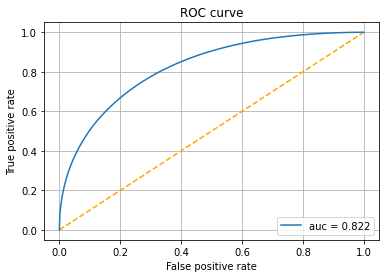

In [11]:
#make ROC curve
drawROC(result)

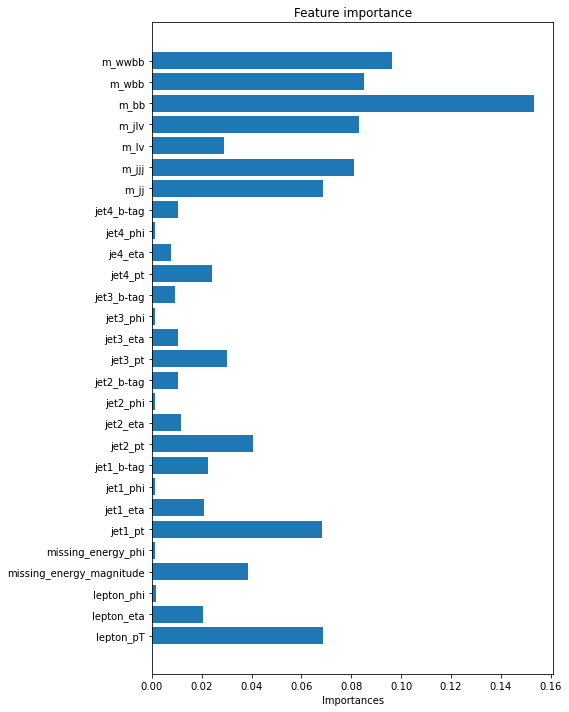

In [12]:
#plot features vs importance
drawFeatures(feature, gbt_model)

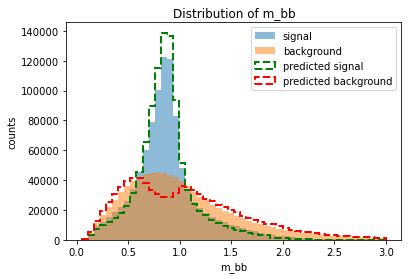

In [13]:
#plot signal vs background with prediction
plotSignalvsBgWithPrediction(test, result, 'm_bb')

# Exercise 2

- try to change the hyperparameters of the GBT model (maxIter=50, maxDepth=10), and check what changes in terms of performances, feature importance, signal versus background separation. Be careful of training time if you increase them too much!

# Hyperparameter scan

- documentation: https://spark.apache.org/docs/latest/ml-tuning.html

In [14]:
#reduce number of events for training if needed
subSample = train.sample(fraction=1.0/10, withReplacement=False).cache()
print('We will use ' +str(subSample.count()) + ' events for the grid search')

We will use 763644 events for the grid search


In [15]:
#Do hyperparameter tuning 
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator

gbt = GBTClassifier(labelCol='label', featuresCol='features', maxIter=10, maxDepth=3)

evaluator=BinaryClassificationEvaluator(metricName='areaUnderROC')

#choose hyperparameter space
paramGrid = ParamGridBuilder()\
  .addGrid(gbt.maxDepth, [1,5])\
  .addGrid(gbt.maxIter, [10,20])\
  .build()

# Exercise 3

- try implementing the cross validation method, and describe what changes (results, training time, performances, ...): do you get the same hyper-parameters?

In [16]:
# n k cross validation (takes 6-8 minutes)
cv = CrossValidator(estimator=gbt, 
                    evaluator=evaluator,
                    estimatorParamMaps=paramGrid,
                    numFolds=10, parallelism=num_workers)  #increase numFolds carefully, tipycally this would be 3 or 10

In [17]:
#or (takes 1-2 minutes)
tvs = TrainValidationSplit(estimator=gbt,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8)# 80% of the data will be used for training, 20% for validation

**TIP:** after starting the following cell, close the Spark monitoring window or it will slow down your notebook display considerably.

In [18]:
#take care, might take long time, 
#%time bestModel = cv.fit(subSample)
%time bestModel = tvs.fit(subSample)

CPU times: user 57.5 s, sys: 14.7 s, total: 1min 12s
Wall time: 16min 13s


In [19]:
#It is possile to see the score obtained (in this case the AUC) for each set of parameters
#zip(bestModel.avgMetrics, paramGrid)

print('maxDepth = '+str(bestModel.bestModel._java_obj.getMaxDepth()))
print('maxIter = '+str(bestModel.bestModel._java_obj.getMaxIter()))

maxDepth = 5
maxIter = 20


In [20]:
# compute accuracy on the test set
result = bestModel.transform(test)

evaluator = BinaryClassificationEvaluator(labelCol='label', metricName="areaUnderROC")
print("Test set AUC = " + str(evaluator.evaluate(result)))

Test set AUC = 0.7784685211857874


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



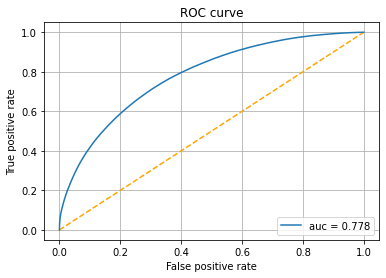

In [21]:
#make ROC curve with best model
drawROC(result)

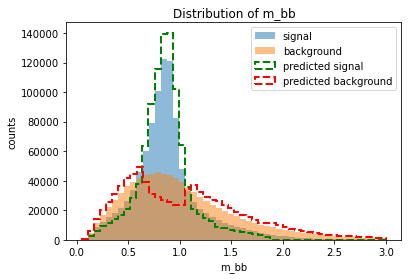

In [22]:
#plot signal vs background with prediction
plotSignalvsBgWithPrediction(test, result, 'm_bb')

In [23]:
#when you're done, stop spark, this will release the resources you're using
spark.stop()